In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import IPython.display
from matplotlib.colors import LinearSegmentedColormap
from typing import List, Tuple, Union

import candle
import candle.functions as F
from candle import Tensor, Parameter, Module, randn
import experiments.trainingutils as tutils
import experiments.textgenutils as gutils

# Neural Tangent Kernel 

Intuition: given a neural network f(x, θ) with **proper initialization** and in the **limit of infinite width**,
1. Lazy Regime: We can show that **gradient descent operates in a small neighbourhood** around the init params θ<sub>0</sub>, which is the "lazy regime" / "kernel regime"
2. Linearization: the Taylor expansion around θ<sub>0</sub> w.r.t θ, **f(x, θ) ≈ f(x, θ<sub>0</sub>) + ϕ(x)<sup>T</sup>∇θ** becomes really accurate in this lazy regime
    - ϕ(x) is the gradient of f(θ, x) w.r.t. θ
3. Therefore, gradient descent on θ is equivalent to optimizing ∇θ in this linear equation
    - AKA **linear regression using the feature map ϕ(x)**!!! (i.e. kernel regression)
4. The kernel matrix NTK(x, x') = ϕ(x)<sup>T</sup>ϕ(x') both **converges** at init and **stays constant** throughout training

## (0) Contents

* [(1) Define Model](#(1)-Define-Model)
* [(2) Random Model Initializations are Gaussian Processes](#(2)-Random-Model-Initializations-are-Gaussian-Processes)
* [(3) Random Trained Models are Gaussian Processes](#(3)-Random-Trained-Models-are-Gaussian-Processes)
* [(4) Empirical NTK at Initialization](#(4)-Empirical-NTK-at-Initialization)
* [(5) NTK evolution throughout training](#(5)-NTK-evolution-throughout-training)
* [(6) Infinite-Width Gradient Descent operates in the "Lazy Regime"](#(6)-Infinite-Width-Gradient-Descent-operates-in-the-"Lazy-Regime")
* [(7) Linearization is Accurate in the Infinite Width Networks](#(7)-Linearization-is-Accurate-in-the-Infinite-Width-Networks)
* [(8) Infinite Width Neural Networks == Kernel Regression](#(8)-Infinite-Width-Neural-Networks-==-Kernel-Regression)

## (1) Define Model

In [3]:
class Linear(Module):
    """NKT-parameterized linear layer."""
    
    def __init__(self,
                 input_nodes: int,
                 output_nodes: int):
        super().__init__()
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes
        
        self.W = Parameter(randn(input_nodes, output_nodes, std=1.0))
        self.b = Parameter(randn(output_nodes, std=0.3))
    
    def forward(self, x):
        return x @ (self.W / np.sqrt(self.input_nodes)) + self.b
        
        
    def __repr__(self):
        return f'Linear({self.input_nodes}, {self.output_nodes})'


class MLP(candle.Module):
    """Simple NTK-parameterized MLP with ReLU activations."""

    def __init__(self, width: int, depth: int):
        super().__init__()
        self.width = width
        self.depth = depth
        
        layers = [Linear(1, width)]
        for _ in range(depth):
            layers.append(Linear(width, width))
        self.layers = candle.ParameterList(layers)
        
        self.output = Linear(width, 1)


    def forward(self, x):
        """Scalar input to scalar output.
        
        Args:
            x (Tensor): shape (batch, 1)
            
        """
        for layer in self.layers:
            x = layer(x)
            x = F.relu(x) 
        return self.output(x).flatten()


## (2) Random Model Initializations are Gaussian Processes

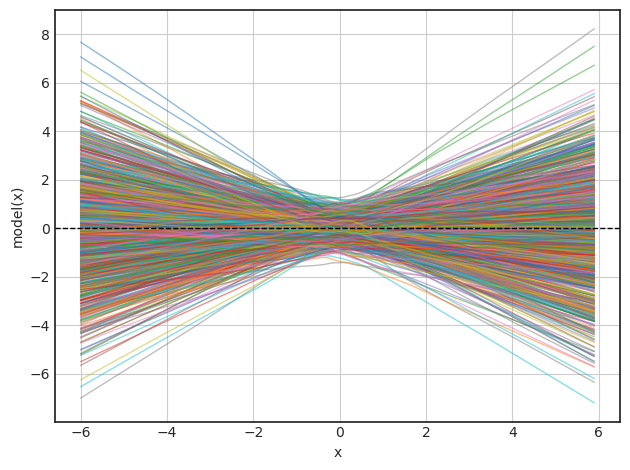

In [4]:
WIDTH = 512
TRIALS = 1000

X_range = Tensor(np.arange(-6, 6, 0.1)).unsqueeze(1)

for _ in range(TRIALS):
    model = MLP(depth=2, width=WIDTH)
    plt.plot(X_range.data.flatten(), model(X_range).data, alpha=0.5, linewidth=1.0)
plt.axhline(0, color='black', linewidth=1.0, linestyle='--')
plt.xlabel('x')
plt.ylabel('model(x)')
plt.grid()
plt.tight_layout()
plt.show()

## (3) Random Trained Models are Gaussian Processes

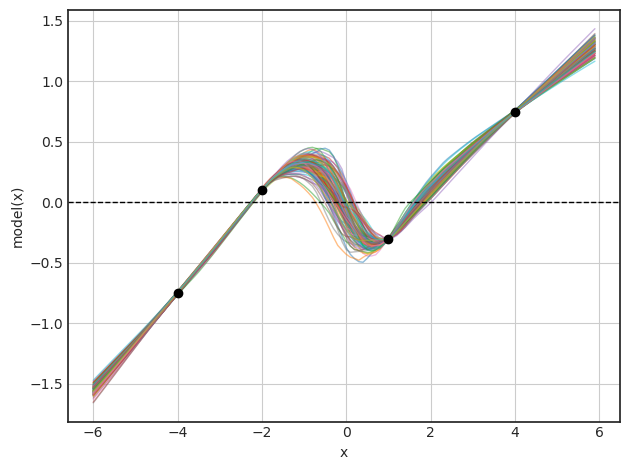

In [5]:
WIDTH = 512
TRIALS = 100
STEPS = 100

X = Tensor(np.array([[-4, -2, 1, 4]]).T)
y = Tensor(np.array([-0.75, 0.10, -0.30, 0.75]))

for _ in range(TRIALS):
    model = MLP(depth=2, width=WIDTH)
    optimizer = candle.optimizer.AdamW(model.parameters(), learning_rate=1e-2)
    
    for step in range(STEPS):
        model.zero_grad()
        
        output = model(X)
        loss = ((output - y) ** 2).mean()
        loss.backward()
        
        optimizer.step()

    plt.plot(X_range.data.flatten(), model(X_range).data, alpha=0.5, linewidth=1.0)

plt.plot(X.data.flatten(), y.data, color='black', marker='o', linewidth=0)

plt.axhline(0, color='black', linewidth=1.0, linestyle='--')
plt.xlabel('x')
plt.ylabel('model(x)')
plt.grid()
plt.tight_layout()
plt.show()

> See https://distill.pub/2019/visual-exploration-gaussian-processes/ `Posterior Distribution`

## (4) Empirical NTK at Initialization

> With proper parameterization, empirical NTK converges as width grows.

In [6]:
def empirical_ntk(model, X):
    """Computes the empirical NTK for some given datapoints.

    Args:
        model (Module): takes in X as input
        X (Tensor): shape (batch, 1)

    """
    jacobians = []
    for x in X:
        model.zero_grad()
        output_i = model(x)
        output_i[0].backward()
        
        jacobian = np.concatenate([p.grad.flatten() for p in model.parameters().values()])
        jacobians.append(jacobian)
    
    jacobians = np.stack(jacobians)  # shape (len(X), num_params)
    
    ntk = jacobians @ jacobians.T

    return ntk

In [7]:
ntk1 = empirical_ntk(MLP(depth=2, width=2048), X)
ntk2 = empirical_ntk(MLP(depth=2, width=8192), X)

ntk1 / ntk2

array([[0.9973833, 0.9891902, 1.0159751, 1.0203536],
       [0.9891902, 0.9949537, 1.0158572, 1.0131932],
       [1.0159751, 1.0158572, 1.0104675, 1.0051138],
       [1.0203536, 1.0131932, 1.0051138, 1.0241975]], dtype=float32)

In [8]:
WIDTHS = [32, 48, 64, 96, 128, 192, 256, 384, 512, 768, 1024]
TRIALS = 100

ntk_norm_by_width = pd.DataFrame()
for width in WIDTHS:
    for trial in range(TRIALS):
        model = MLP(depth=2, width=width)
        ntk = empirical_ntk(model, X)
        
        ntk_norm_by_width.loc[width, trial] = np.linalg.norm(ntk)

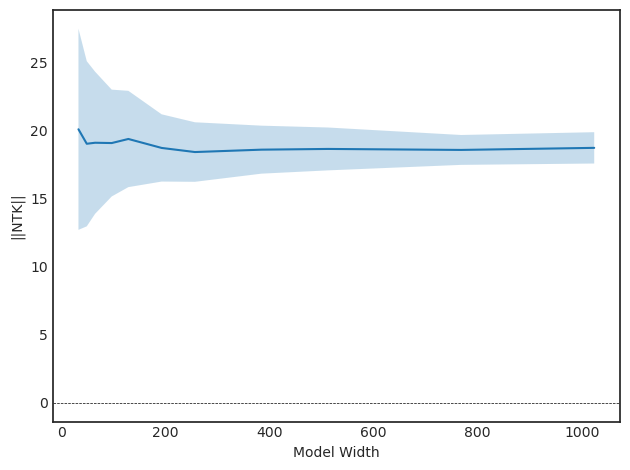

In [9]:
mean = ntk_norm_by_width.mean(axis=1)
std = ntk_norm_by_width.std(axis=1)

mean.plot()
plt.fill_between(std.index, mean - std, mean + std, alpha=0.25)

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlabel('Model Width')
plt.ylabel('||NTK||')
plt.tight_layout()
plt.show()

## (5) NTK evolution throughout training

> With sufficiently large width and sufficiently small LR, empirical NTK stays constant over the course of training.

In [10]:
WIDTHS = [32, 48, 64, 96, 128, 192, 256, 384, 512, 768, 1024, 1536, 2048]
STEPS = 50

ntk_diff_by_step = pd.DataFrame()

for width in WIDTHS:
    model = MLP(depth=2, width=width)
    optimizer = candle.optimizer.SGD(model.parameters(), learning_rate=1e-7)
    
    initial_ntk = empirical_ntk(model, X)
    
    for step in range(STEPS):
        model.zero_grad()
        
        output = model(X)
        loss = ((output - y) ** 2).mean()
        loss.backward()
        
        optimizer.step()
        
        ntk = empirical_ntk(model, X)
        
        ntk_diff_by_step.loc[step, width] = np.linalg.norm(initial_ntk - ntk) / np.linalg.norm(initial_ntk)

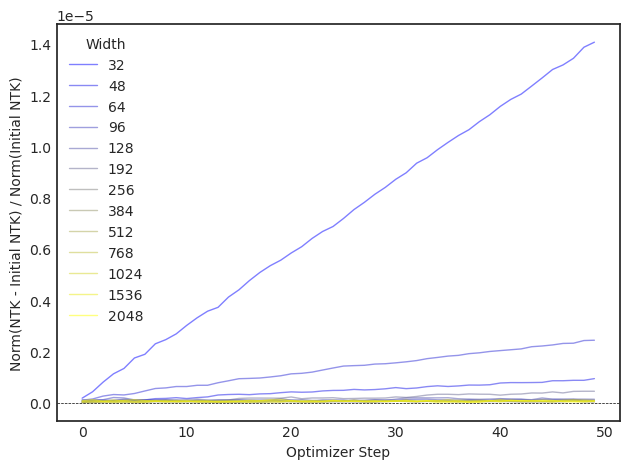

In [11]:
cmap = LinearSegmentedColormap.from_list('blue_to_red', ['blue', 'yellow'])
colors = cmap(np.linspace(0, 1, ntk_diff_by_step.shape[1]))

for (i, col) in enumerate(ntk_diff_by_step):
    plt.plot(ntk_diff_by_step.index, ntk_diff_by_step[col], 
             color=colors[i], alpha=0.5, linewidth=1.0, label=col)

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlabel('Optimizer Step')
plt.ylabel('Norm(NTK - Initial NTK) / Norm(Initial NTK)')
plt.legend(title='Width')
plt.tight_layout()
plt.show()

## (6) Infinite-Width Gradient Descent operates in the "Lazy Regime"

> Gradient descent operates in a small neighbourhood around the init params θ<sub>0</sub>, which is the "lazy regime" / "kernel regime"

In [12]:
WIDTHS = [16, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512, 768, 1024, 1536, 2048]
STEPS = 100

loss_by_step = pd.DataFrame()
param_diff_by_step = pd.DataFrame()

for width in WIDTHS:
    model = MLP(depth=2, width=width)
    optimizer = candle.optimizer.AdamW(model.parameters(), learning_rate=1e-3)
    
    initial_params = np.concatenate([p.data.flatten() for p in model.parameters().values()])
    
    for step in range(STEPS):
        model.zero_grad()
        
        output = model(X)
        loss = ((output - y) ** 2).mean()
        loss.backward()
        
        optimizer.step()
    
        params = np.concatenate([p.data.flatten() for p in model.parameters().values()])
        
        loss_by_step.loc[step, width] = float(loss.data)
        param_diff_by_step.loc[step, width] = np.linalg.norm(initial_params - params) / np.linalg.norm(initial_params)

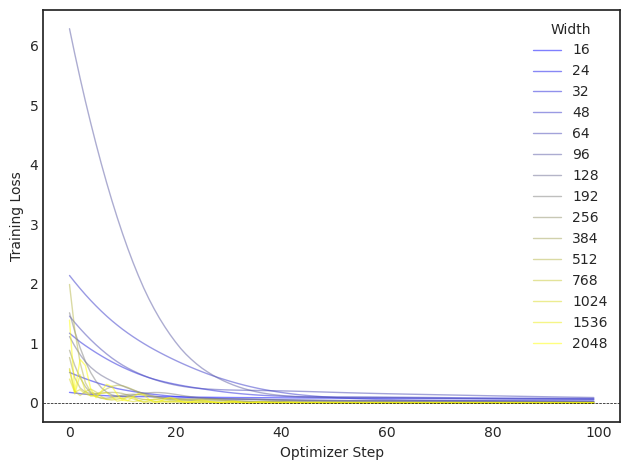

In [13]:
cmap = LinearSegmentedColormap.from_list('blue_to_red', ['blue', 'yellow'])
colors = cmap(np.linspace(0, 1, loss_by_step.shape[1]))

for (i, col) in enumerate(loss_by_step):
    plt.plot(loss_by_step.index, loss_by_step[col], 
             color=colors[i], alpha=0.5, linewidth=1.0, label=col)

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlabel('Optimizer Step')
plt.ylabel('Training Loss')
plt.legend(title='Width')
plt.tight_layout()
plt.show()

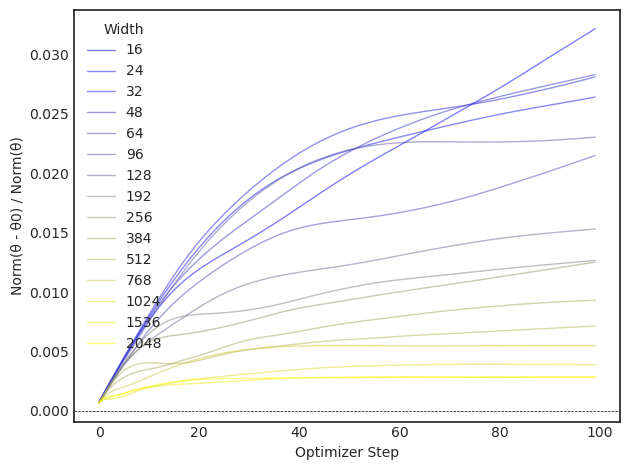

In [14]:
cmap = LinearSegmentedColormap.from_list('blue_to_red', ['blue', 'yellow'])
colors = cmap(np.linspace(0, 1, param_diff_by_step.shape[1]))

for (i, col) in enumerate(param_diff_by_step):
    plt.plot(param_diff_by_step.index, param_diff_by_step[col], 
             color=colors[i], alpha=0.5, linewidth=1.0, label=col)

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlabel('Optimizer Step')
plt.ylabel('Norm(θ - θ0) / Norm(θ)')
plt.legend(title='Width')
plt.tight_layout()
plt.show()

## (7) Linearization is Accurate in the Infinite Width Networks

> - The Taylor expansion around θ<sub>0</sub> w.r.t θ, f(x, θ) ≈ f(x, θ<sub>0</sub>) + ϕ(x)<sup>T</sup>∇θ becomes really accurate in this lazy regime
     - ϕ(x) is the gradient of f(θ, x) w.r.t. θ

In [15]:
def feature_map(model, x):
    """Returns feature map ϕ(x) := the gradient of f(θ, x) w.r.t. θ.

    Args:
        model (Module): takes in x as input
        x (Tensor): shape (1,)
        
    """
    model.zero_grad()
    output_i = model(x)
    output_i[0].backward()
    
    jacobian = np.concatenate([p.grad.flatten() for p in model.parameters().values()])
    
    return jacobian
    

def compare_f_vs_linearized_f(width: int):
    """Compares the true f(θ, x) vs the linearized approximation of f(θ, x) for a given width."""
    model = MLP(depth=2, width=width)
    
    # ϕ(x).T
    X_featurized = np.stack([feature_map(model, x) for x in X_range])
    
    # f(x, θ_0)
    y_initial = [float(model(x).data[0]) for x in X_range]
    
    # Train model
    optimizer = candle.optimizer.AdamW(model.parameters(), learning_rate=1e-3)
    
    initial_params = np.concatenate([p.data.flatten() for p in model.parameters().values()])

    STEPS = 500
    for step in range(STEPS):
        model.zero_grad()
        
        output = model(X)
        loss = ((output - y) ** 2).mean()
        loss.backward()
        
        optimizer.step()
    
    final_params = np.concatenate([p.data.flatten() for p in model.parameters().values()])
    
    # ∇θ
    delta_params = final_params - initial_params
    
    # Linearized approximation, f(x, θ) ≈ f(x, θ_0) + ϕ(x).T @ ∇θ
    f_linearized = y_initial + X_featurized @ delta_params
    
    # True model
    f = model(X_range).data
    
    # Plot
    plt.plot(X_range.data.flatten(), f, alpha=0.85, linewidth=1.0, label='True f(θ, x)')
    plt.plot(X_range.data.flatten(), f_linearized, alpha=0.85, linewidth=1.0, label='Linearized approximation of f(θ, x)')
    plt.plot(X.data.flatten(), y.data, color='black', marker='o', linewidth=0, alpha=0.85)
    
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid()
    plt.title(f'True f(θ, x) vs Linearized f(θ, x), width {width}')
    plt.xlabel('x')
    plt.legend()
    plt.tight_layout()
    plt.show()

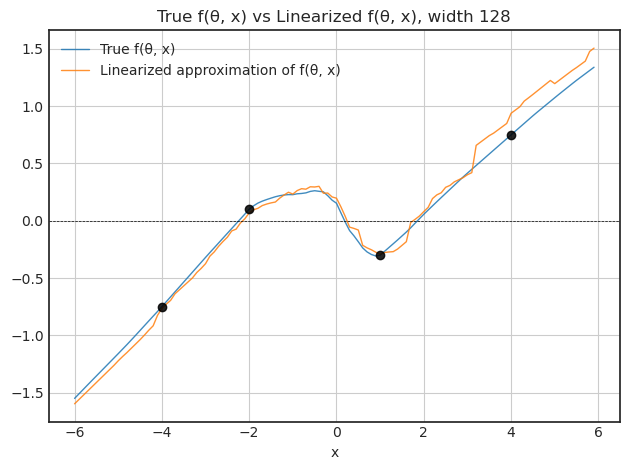

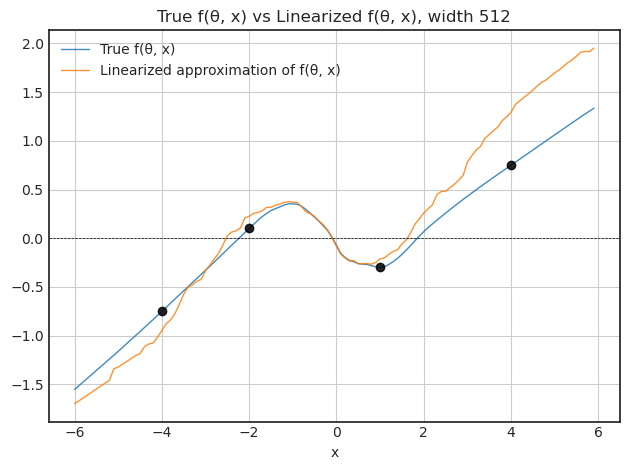

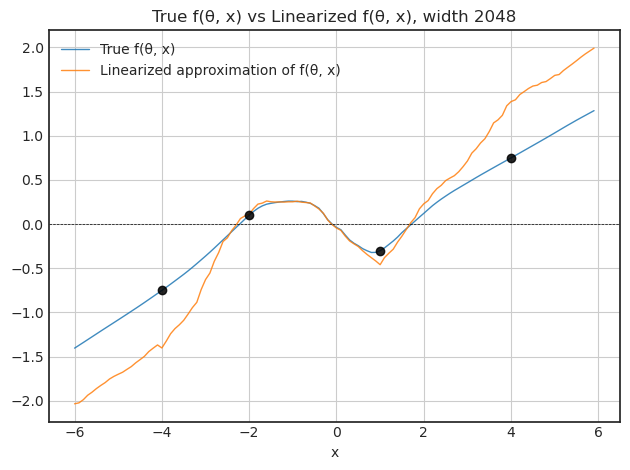

In [16]:
compare_f_vs_linearized_f(width=128)
compare_f_vs_linearized_f(width=512)
compare_f_vs_linearized_f(width=2048)

## (8) Infinite Width Neural Networks == Kernel Regression

> More precisely, infinite width networks before/during/after training are Gaussian processes whose posterior mean is the kernel regression estimator  
During training, the mean evolves according to kernel gradient descent with the NTK kernel.

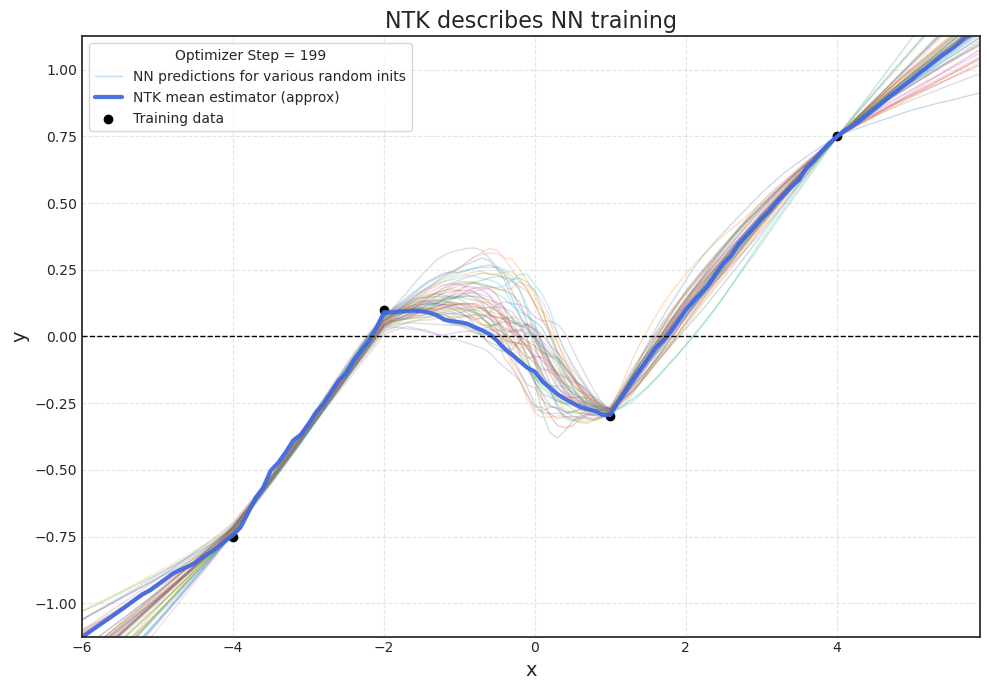

In [21]:
WIDTH = 1024
WIDE_WIDTH = 2048
N_MODELS = 50
STEPS = 200
LEARNING_RATE = 1e-1

# NN setup

models = [MLP(depth=2, width=WIDTH) for _ in range(N_MODELS)]
optimizers = [candle.optimizer.SGD(model.parameters(), learning_rate=LEARNING_RATE) for model in models]

# NTK setup

model = MLP(depth=2, width=WIDE_WIDTH)
X_featurized = np.stack([feature_map(model, x) for x in X])
X_range_featurized = np.stack([feature_map(model, x) for x in X_range])

beta = np.zeros(X_featurized.shape[1])

for step in range(STEPS):
    fig = plt.figure(figsize=(10, 7))
    
    # NN gradient descent
    for (i, (model, optimizer)) in enumerate(zip(models, optimizers)):
        model.zero_grad()
        
        output = model(X)
        loss = ((output - y) ** 2).mean()
        loss.backward()
        
        optimizer.step()

        if i == 0:
            label = 'NN predictions for various random inits'
        else:
            label = None
        plt.plot(X_range.data.flatten(), model(X_range).data, alpha=0.25, linewidth=1.0, label=label)

    # Kernel gradient descent
    beta_grad = X_featurized.T @ (X_featurized @ beta - y.data) * (2 / len(X))
    # beta -= LEARNING_RATE * beta_grad
    beta -= LEARNING_RATE * beta_grad + 1e-6 * beta

    plt.plot(X_range.data.flatten(), X_range_featurized @ beta, alpha=0.95, linewidth=3, color='royalblue', label='NTK mean estimator (approx)')
    
    plt.scatter(X.data.flatten(), y.data, color='black', marker='o', label='Training data')
    plt.axhline(0, color='black', linewidth=1, linestyle='--')
    plt.ylim(top=abs(y.data).max() * 1.5, bottom=-abs(y.data).max() * 1.5)
    plt.xlim(left=X_range.data.min(), right=X_range.data.max())
    
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.title('NTK describes NN training', fontsize=16)
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title=f'Optimizer Step = {step}', loc='upper left', frameon=True)
    plt.tight_layout()
    plt.show()
        
    IPython.display.clear_output(wait=True)